#Set up

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch-scatter==2.1.2 -f https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
!pip install torch-geometric
!pip install shap

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 2.6 MB/s eta 0:00:00


# Model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from torch.nn.parameter import Parameter
from torch_scatter import scatter_mean
# from torch_geometric.nn import MetaLayer


TIME_WINDOW = 24
PRED_LEN = 6

class Model(nn.Module):
    def __init__(self, mode, encoder, w_init, w, x_em, date_em, loc_em, edge_h, gnn_h, gnn_layer, city_num, group_num, pred_step, device):
        super(Model, self).__init__()
        self.device = device
        self.mode = mode
        self.encoder = encoder
        self.w_init = w_init
        self.x_em = x_em
        self.city_num = city_num
        self.group_num = group_num
        self.edge_h = edge_h
        self.gnn_layer = gnn_layer
        self.pred_step = pred_step

        if self.encoder == 'self':
            self.encoder_layer = TransformerEncoderLayer(8, nhead=4, dim_feedforward=256)
            self.x_embed = Lin(TIME_WINDOW*8, x_em)

        elif self.encoder == 'lstm':
            self.input_LSTM = nn.LSTM(8,x_em,num_layers=1,batch_first=True)


        if self.w_init == 'rand':
            self.w = Parameter(torch.randn(city_num,group_num).to(device,non_blocking=True),requires_grad=True)

        elif self.w_init == 'group':
            self.w = Parameter(w,requires_grad=True)


        self.loc_embed = Lin(2, loc_em)

        self.u_embed1 = nn.Embedding(12, date_em) #month
        self.u_embed2 = nn.Embedding(7, date_em) #week
        self.u_embed3 = nn.Embedding(24, date_em) #hour

        self.edge_inf = Seq(Lin(x_em*2+date_em*3+loc_em*2,edge_h),ReLU(inplace=False))

        self.group_gnn = nn.ModuleList([NodeModel(x_em+loc_em,edge_h,gnn_h)])

        for i in range(self.gnn_layer-1):
            self.group_gnn.append(NodeModel(gnn_h,edge_h,gnn_h))

        self.global_gnn = nn.ModuleList([NodeModel(x_em+gnn_h,1,gnn_h)])

        for i in range(self.gnn_layer-1):
            self.global_gnn.append(NodeModel(gnn_h,1,gnn_h))

        if self.mode == 'feedback':
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,1),ReLU(inplace=False))

        if self.mode == 'probe_x' or self.mode == 'probe_encoded' or self.mode == 'probe_woAttn':
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,self.pred_step),ReLU(inplace=False))
            self.probe_gnn = nn.ModuleList([NodeModel(x_em,1,gnn_h)])

            for i in range(self.gnn_layer-1):
                self.probe_gnn.append(NodeModel(gnn_h,1,gnn_h))

        if self.mode == 'temp':
            self.decoder = DecoderModule(x_em,edge_h,gnn_h,gnn_layer,city_num,group_num,device)
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,self.pred_step),ReLU(inplace=False))
            self.TemporalAggregateMLP = Seq(Lin(gnn_h+8,gnn_h),ReLU(inplace=False))

        if self.mode == 'both':
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,1),ReLU(inplace=False))
            self.TemporalAggregateMLP = Seq(Lin(gnn_h+8,gnn_h),ReLU(inplace=False))

        if self.mode == 'feedbackDecoder':
            self.decoder = DecoderModule(x_em,edge_h,gnn_h,gnn_layer,city_num,group_num,device)
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,1),ReLU(inplace=False))

        if self.mode == 'baseline':
            self.decoder = DecoderModule(x_em,edge_h,gnn_h,gnn_layer,city_num,group_num,device)
            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,self.pred_step),ReLU(inplace=False))

        if self.mode == 'final':
            self.x_embed = Lin(TIME_WINDOW*8, x_em)

            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,self.pred_step),ReLU(inplace=False))
            self.global_gnn = nn.ModuleList([NodeModel(x_em,1,gnn_h)])

            for i in range(self.gnn_layer-1):
                self.global_gnn.append(NodeModel(gnn_h,1,gnn_h))

        elif self.mode == 'final2':
            self.encoder_layer = TransformerEncoderLayer(x_em, nhead=4, dim_feedforward=256, batch_first=True)
            self.x_embed = Lin(TIME_WINDOW*8, x_em)

            self.predMLP = Seq(Lin(gnn_h,16),ReLU(inplace=False),Lin(16,self.pred_step),ReLU(inplace=False))
            self.global_gnn = nn.ModuleList([NodeModel(x_em,1,gnn_h)])

            for i in range(self.gnn_layer-1):
                self.global_gnn.append(NodeModel(gnn_h,1,gnn_h))


    def batchInput(self, x, edge_w, edge_index):
        # new_x
        sta_num = x.shape[1]
        x = x.reshape(-1, x.shape[-1])

        # edge_w
        edge_w = edge_w.reshape(-1,edge_w.shape[-1])

        # edge_index
        for i in range(edge_index.size(0)):
            edge_index[i,:] = torch.add(edge_index[i,:], i*sta_num)
        edge_index = edge_index.transpose(0,1)
        edge_index = edge_index.reshape(2,-1)

        return x, edge_w, edge_index


    def forward(self, x, u, edge_index, edge_w, loc):
        # Shape: (batch, 209, 24, 8)
        if self.mode == 'final':
            x = x.reshape(-1,self.city_num, TIME_WINDOW*x.shape[-1]) # Shape: (batch, 209, 24*8)
            x = self.x_embed(x) # Linear(24*8, x_em:32) Shape: (batch, 209, 32)

            """ Update """
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)
            # edge_w Shape: (batch, 4112) -> (batch*4112, 1)
            # edge_index Shape: (batch, 2, 4112) -> (2, batch*4112)

            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)


            """ Final Forcasting """
            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)
            return res

        if self.mode == 'final2':
            x = x.reshape(-1,self.city_num, TIME_WINDOW*x.shape[-1]) # Shape: (batch, 209, 24*8)
            x = self.x_embed(x) # Linear(24*8, x_em:32) Shape: (batch, 209, 32)
            x = self.encoder_layer(x) # Shape: (batch, 209, 32)

            """ Update """
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)
            # edge_w Shape: (batch, 4112) -> (batch*4112, 1)
            # edge_index Shape: (batch, 2, 4112) -> (2, batch*4112)

            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)


            """ Final Forcasting """
            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)

            return res


        if self.mode == 'probe_woAttn':
            x = x.reshape(-1,self.city_num, TIME_WINDOW*x.shape[-1]) # Shape: (batch, 209, 24*8)
            x = self.x_embed(x) # Linear(24*8, x_em:32) Shape: (batch, 209, 32)

            """ Probe """
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)

            for i in range(self.gnn_layer):
                new_x = self.probe_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)

            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)

            return res



        ''' Self Attention '''
        x = x.reshape(-1,x.shape[2],x.shape[3]) # Shape: (209*batch, 24, 8)
        x = x.transpose(0,1) # Shape: (24, batch*209, 8)
        x = self.encoder_layer(x) # self-attention, Shape: (24, batch*209, 8)
        x = x.transpose(0,1) # Shape: (batch*209, 24, 8)


        if self.mode == 'temp' or self.mode == 'both':
            x2 = x.reshape(-1,self.city_num,x.shape[1],x.shape[2]) # Temporal
            x2 = torch.index_select(x2, dim=2, index=torch.tensor([3, 7, 11, 15, 19, 23]).to(self.device)) ## ( batch size, num of city, selected 6h, 8features )
            x2 = x2.transpose(1,2) ## ( batch size, selected 6h , num of city, 8features ) [batch size, 6, 209, 8]

            h_other5 = x2[:, :-1, :, :]  # [batch size, 5, 209, 8]
            h_other5 = h_other5.reshape(-1,h_other5.shape[1]*h_other5.shape[2],h_other5.shape[3])  # [batch size, 1045, 8]

            h24 = x2[:, -1:, :, :]  # [batch size, 1, 209, 8]
            h24 = h24.reshape(-1,h24.shape[2],h24.shape[3]) # [batch size, 209, 8]
            h24 = h24.transpose(1,2)

            attention_scores = torch.matmul(h_other5, h24)   # [batch size, 1045, 209]
            attention_scores = attention_scores.reshape(-1,5,209,attention_scores.shape[2])  # [batch size, 5, 209, 209]
            attention_weights = F.softmax(attention_scores, dim=1)  # [batch size, 5, 209, 209]

            h_other5 = h_other5.reshape(-1,5,209,h_other5.shape[2]) # [batch size, 5, 209, 8]
            h_other5 = h_other5.transpose(2,3) # [batch size, 5, 8, 209]

            attention_weighted_sum = torch.matmul(h_other5, attention_weights) # [batch size, 5, 8, 209]
            attention_weighted_sum = attention_weighted_sum.transpose(2,3)
            x2 = torch.sum(attention_weighted_sum, dim=1)  # [batch size, 209, 8]

        x = x.reshape(-1,self.city_num, TIME_WINDOW*x.shape[-1]) # Shape: (batch, 209, 24*8)
        x = self.x_embed(x) # Linear(24*8, x_em:32) Shape: (batch, 209, 32)


        if self.mode == 'probe_x':
            """ Probe """
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)

            for i in range(self.gnn_layer):
                new_x = self.probe_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)

            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)

            return res


        ''' Differentiable grouping network
            City to City Group    '''

        # S
        w = F.softmax(self.w, dim=1) # w: (209, group_num:15)
        w1 = w.transpose(0, 1)
        w1 = w1.unsqueeze(dim=0)
        w1 = w1.repeat_interleave(x.size(0), dim=0) # w1: (batch, group_num, 209)

        # city group
        loc = self.loc_embed(loc) # Linear(2, loc_em:12), shape: (batch, 209, 12)
        x_loc = torch.cat([x,loc],dim=-1) # X, L (batch, 32+12=44)
        g_x = torch.bmm(w1,x_loc) # g_x: (batch, group_num, 44)



        ''' Group Correlation Encoding Module
            Edge Connection '''

        # T
        u_em1 = self.u_embed1(u[:,0]) # Embedding(12, date_em=4) Shape: (batch, 209, 4)
        u_em2 = self.u_embed2(u[:,1]) # Embedding(7, date_em=4)
        u_em3 = self.u_embed3(u[:,2]) # Embedding(24, date_em=4)
        u_em = torch.cat([u_em1,u_em2,u_em3],dim=-1) # Shape: (batch, 209, 12)

        # Edge connection
        for i in range(self.group_num):
            for j in range(self.group_num):
                if i == j: continue

                # ReLU(enc(Z_i, Z_j, T))
                g_edge_input = torch.cat([g_x[:,i],g_x[:,j],u_em],dim=-1) # Shape: (batch, 44+44+12=100)
                tmp_g_edge_w = self.edge_inf(g_edge_input) # Shape: (batch, 12)

                tmp_g_edge_w = tmp_g_edge_w.unsqueeze(dim=0) # Shape: (1, batch, 209, 12)
                tmp_g_edge_index = torch.tensor([i,j]).unsqueeze(dim=0).to(self.device,non_blocking=True) # Shape: (1, 2)

                if i == 0 and j == 1:
                    g_edge_w = tmp_g_edge_w # Shape: (1, batch, 12)
                    g_edge_index = tmp_g_edge_index # Shape: (1, 2)
                else:
                    g_edge_w = torch.cat([g_edge_w,tmp_g_edge_w],dim=0) # Shape: (210, batch, 12)
                    g_edge_index = torch.cat([g_edge_index,tmp_g_edge_index],dim=0) # Shape: (210, 2)




        ''' Group Message Passing
              Group Update '''

        g_edge_w = g_edge_w.transpose(0,1)
        g_edge_index = g_edge_index.unsqueeze(dim=0)
        g_edge_index = g_edge_index.repeat_interleave(u_em.shape[0],dim=0)
        g_edge_index = g_edge_index.transpose(1,2)
        g_x, g_edge_w, g_edge_index = self.batchInput(g_x, g_edge_w, g_edge_index)

        for i in range(self.gnn_layer):
            g_x = self.group_gnn[i](g_x,g_edge_index,g_edge_w)

        g_x = g_x.reshape(-1,self.group_num,g_x.shape[-1])



        ''' City Group to City '''
        # S
        w2 = w.unsqueeze(dim=0)
        w2 = w2.repeat_interleave(g_x.size(0), dim=0)
        new_x = torch.bmm(w2, g_x) # Shape: (batch, 209, 32)


        if self.mode == 'both':
            # x Shape: (batch:64, 209, 32)

            """ City Update """
            new_x_update = torch.cat([x,new_x],dim=-1)
            edge_w = edge_w.unsqueeze(dim=-1)
            tmp_edge_index = edge_index.clone()
            new_x_update, edge_w, tmp_edge_index = self.batchInput(new_x_update, edge_w, tmp_edge_index)

            for i in range(self.gnn_layer):
                new_x_update = self.global_gnn[i](new_x_update,tmp_edge_index,edge_w)

            """ Temporal """
            x2 = x2.reshape(-1,x2.shape[-1])
            temp_x = torch.cat([x2, new_x_update],dim=-1)
            temp_x = self.TemporalAggregateMLP(temp_x)
            temp_x = temp_x.reshape(-1, self.city_num, temp_x.shape[-1])

            for i in range(self.pred_step):

                """ Feedback """
                # x Shape: (batch, 209, 32)
                new_x = torch.cat([temp_x, new_x], dim=-1) # Shape: (batch, 209, 64)


                """ City Update """
                tmp_edge_index = edge_index.clone()
                new_x, tmp_edge_w, tmp_edge_index = self.batchInput(new_x, edge_w, tmp_edge_index) # Shape: (batch*209, 64)

                for j in range(self.gnn_layer):
                    new_x = self.global_gnn[j](new_x, tmp_edge_index, tmp_edge_w) # Shape: (batch*209, 32)


                """ Final Forcasting """
                # new_x = self.decoder(new_x, self.w, g_edge_index, g_edge_w, tmp_edge_index, tmp_edge_w)
                tmp_res = self.predMLP(temp_x) # Shape: (batch*209, 1)
                tmp_res = tmp_res.reshape(-1, self.city_num) # Shape: (batch, 209)
                tmp_res = tmp_res.unsqueeze(dim=-1) # Shape: (batch, 209, 1)
                if i == 0:
                    res = tmp_res
                else:
                    res = torch.cat([res,tmp_res],dim=-1) # Shape: (batch, 209, i+1)

                new_x = new_x.reshape(-1, self.city_num, self.x_em) # Shape: (batch, 209, 32)


        if self.mode == 'temp':
            """ City Update """
            new_x = torch.cat([x,new_x],dim=-1)
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(new_x, edge_w, edge_index)

            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x,edge_index,edge_w)

            """ Temporal """
            x2 = x2.reshape(-1,x2.shape[-1])
            new_x = torch.cat([x2,new_x],dim=-1)
            new_x = self.TemporalAggregateMLP(new_x)

            """ Final Forcasting """
            new_x = self.decoder(new_x, self.w, g_edge_index, g_edge_w, edge_index, edge_w) # Shape: (batch*209, 32)
            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)


        if self.mode == 'feedback':
            edge_w = edge_w.unsqueeze(dim=-1)
            output = x.reshape(-1, self.city_num, x.shape[-1])

            for i in range(self.pred_step):

                """ Feedback """
                # x Shape: (batch, 209, 32)
                tmp_x = torch.cat([output, new_x], dim=-1) # Shape: (batch, 209, 64)


                """ City Update """
                tmp_edge_index = edge_index.clone()
                tmp_x, tmp_edge_w, tmp_edge_index = self.batchInput(tmp_x, edge_w, tmp_edge_index) # Shape: (batch*209, 64)
                for j in range(self.gnn_layer):
                    tmp_x = self.global_gnn[j](tmp_x, tmp_edge_index, tmp_edge_w) # Shape: (batch*209, 32)


                """ Final Forcasting """
                tmp_res = self.predMLP(tmp_x) # Shape: (batch*209, 1)
                tmp_res = tmp_res.reshape(-1, self.city_num) # Shape: (batch, 209)
                tmp_res = tmp_res.unsqueeze(dim=-1) # Shape: (batch, 209, 1)
                if i == 0:
                    res = tmp_res
                else:
                    res = torch.cat([res,tmp_res],dim=-1) # Shape: (batch, 209, i+1)

                output = tmp_x.reshape(-1, self.city_num, self.x_em) # Shape: (batch, 209, 32)




        if self.mode == 'probe_encoded':
            """ City Update """
            new_x = torch.cat([x,new_x],dim=-1) # Shape: (batch:64, 209, 64)
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(new_x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)
            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)


            """ Probe """
            new_x = new_x.reshape(-1, new_x.shape[-1])

            for i in range(self.gnn_layer):
                new_x = self.probe_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)

            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)

            return res


        if self.mode == 'feedbackDecoder':
            """ City Update """
            new_x = torch.cat([x,new_x],dim=-1) # Shape: (batch:64, 209, 64)
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(new_x, edge_w, edge_index)

            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x,edge_index,edge_w)


            """ Final Forcasting """
            for i in range(self.pred_step):
                new_x = self.decoder(new_x, self.w, g_edge_index, g_edge_w, edge_index, edge_w)
                tmp_res = self.predMLP(new_x)
                tmp_res = tmp_res.reshape(-1,self.city_num)
                tmp_res = tmp_res.unsqueeze(dim=-1)
                if i == 0:
                    res = tmp_res
                else:
                    res = torch.cat([res,tmp_res],dim=-1)


        if self.mode == 'baseline':
            """ City Update """
            new_x = torch.cat([x,new_x],dim=-1) # Shape: (batch, 209, 64)
            edge_w = edge_w.unsqueeze(dim=-1)
            new_x, edge_w, edge_index = self.batchInput(new_x, edge_w, edge_index)
            # new_x Shape: (batch, 209, 64) -> (batch*209, 64)
            # edge_w Shape: (batch, 4112) -> (batch*4112, 1)
            # edge_index Shape: (batch, 2, 4112) -> (2, batch*4112)

            for i in range(self.gnn_layer):
                new_x = self.global_gnn[i](new_x, edge_index, edge_w) # Shape: (batch*209, 32)


            """ Final Forcasting """
            new_x = self.decoder(new_x, self.w, g_edge_index, g_edge_w, edge_index, edge_w) # Shape: (batch*209, 32)
            res = self.predMLP(new_x)
            res = res.reshape(-1,self.city_num,self.pred_step) # Shape: (batch, 209, 6)


        return res

class DecoderModule(nn.Module):
    def __init__(self,x_em,edge_h,gnn_h,gnn_layer,city_num,group_num,device):
        super(DecoderModule, self).__init__()
        self.device = device
        self.city_num = city_num
        self.group_num = group_num
        self.gnn_layer = gnn_layer
        self.x_embed = Lin(gnn_h, x_em)
        self.group_gnn = nn.ModuleList([NodeModel(x_em,edge_h,gnn_h)])
        for i in range(self.gnn_layer-1):
            self.group_gnn.append(NodeModel(gnn_h,edge_h,gnn_h))
        self.global_gnn = nn.ModuleList([NodeModel(x_em+gnn_h,1,gnn_h)])
        for i in range(self.gnn_layer-1):
            self.global_gnn.append(NodeModel(gnn_h,1,gnn_h))

    def forward(self, x, trans_w, g_edge_index, g_edge_w, edge_index, edge_w):
        x = self.x_embed(x)
        x = x.reshape(-1,self.city_num,x.shape[-1])

        # S
        w = Parameter(trans_w,requires_grad=False).to(self.device,non_blocking=True)
        w1 = w.transpose(0,1)
        w1 = w1.unsqueeze(dim=0)
        w1 = w1.repeat_interleave(x.size(0), dim=0)
        g_x = torch.bmm(w1, x)
        g_x = g_x.reshape(-1, g_x.shape[-1])


        for i in range(self.gnn_layer):
            g_x = self.group_gnn[i](g_x, g_edge_index, g_edge_w)
        g_x = g_x.reshape(-1, self.group_num, g_x.shape[-1])

        # S
        w2 = w.unsqueeze(dim=0)
        w2 = w2.repeat_interleave(g_x.size(0), dim=0)
        new_x = torch.bmm(w2,g_x)

        # H
        new_x = torch.cat([x,new_x],dim=-1)
        new_x = new_x.reshape(-1,new_x.shape[-1])

        for i in range(self.gnn_layer):
            new_x = self.global_gnn[i](new_x,edge_index,edge_w)

        return new_x


class NodeModel(torch.nn.Module):
    def __init__(self,node_h,edge_h,gnn_h):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = Seq(Lin(node_h+edge_h,gnn_h), ReLU(inplace=False))
        self.node_mlp_2 = Seq(Lin(node_h+gnn_h,gnn_h), ReLU(inplace=False))

    def forward(self, x, edge_index, edge_attr):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)
        return self.node_mlp_2(out)

# Dataset

In [5]:
import numpy as np
import pandas as pd
import os

import torch
import torch.utils.data as Data

os.chdir('/content/drive/MyDrive/AI_Project/AIP_Project-main')
path = './data'

class trainDataset(Data.Dataset):
	def __init__(self, transform=None, train=True):
		self.x = np.load(os.path.join(path,'train_x.npy'),allow_pickle=True)
		self.u = np.load(os.path.join(path,'train_u.npy'),allow_pickle=True)
		self.y = np.load(os.path.join(path,'train_y.npy'),allow_pickle=True)
		self.edge_w = np.load(os.path.join(path,'edge_w.npy'),allow_pickle=True)
		self.edge_index = np.load(os.path.join(path,'edge_index.npy'),allow_pickle=True)
		self.loc = np.load(os.path.join(path,'loc_filled.npy'),allow_pickle=True)
		self.loc = self.loc.astype(float)


	def __getitem__(self, index):
		x = torch.FloatTensor(self.x[index]) #(24, 209, 8)
		x = x.transpose(0,1) #(209, 24, 8)
		y = torch.FloatTensor(self.y[index])
		y = y.transpose(0,1)
		u = torch.tensor(self.u[index])
		edge_index = torch.tensor(self.edge_index)
		# edge_index = edge_index.expand((x.size[0],edge_index.size[0],edge_index.size[1]))
		edge_w = torch.FloatTensor(self.edge_w)
		# edge_w = edge_w.expand((x.size[0],edge_w.size[0]))
		loc = torch.FloatTensor(self.loc)

		return [x,u,y,edge_index,edge_w,loc]

	def __len__(self):
		return self.x.shape[0]

class valDataset(Data.Dataset):
	def __init__(self, transform=None, train=True):
		self.x = np.load(os.path.join(path,'val_x.npy'),allow_pickle=True)
		self.u = np.load(os.path.join(path,'val_u.npy'),allow_pickle=True)
		self.y = np.load(os.path.join(path,'val_y.npy'),allow_pickle=True)
		self.edge_w = np.load(os.path.join(path,'edge_w.npy'),allow_pickle=True)
		self.edge_index = np.load(os.path.join(path,'edge_index.npy'),allow_pickle=True)
		self.loc = np.load(os.path.join(path,'loc_filled.npy'),allow_pickle=True)
		self.loc = self.loc.astype(float)


	def __getitem__(self, index):
		x = torch.FloatTensor(self.x[index])
		x = x.transpose(0,1)
		y = torch.FloatTensor(self.y[index])
		y = y.transpose(0,1)
		u = torch.tensor(self.u[index])
		edge_index = torch.tensor(self.edge_index)
		# edge_index = edge_index.expand((x.size[0],edge_index.size[0],edge_index.size[1]))
		edge_w = torch.FloatTensor(self.edge_w)
		# edge_w = edge_w.expand((x.size[0],edge_w.size[0]))
		loc = torch.FloatTensor(self.loc)

		return [x,u,y,edge_index,edge_w,loc]

	def __len__(self):
		return self.x.shape[0]

class testDataset(Data.Dataset):
	def __init__(self, transform=None, train=True):
		self.x = np.load(os.path.join(path,'test_x.npy'),allow_pickle=True)
		self.u = np.load(os.path.join(path,'test_u.npy'),allow_pickle=True)
		self.y = np.load(os.path.join(path,'test_y.npy'),allow_pickle=True)
		self.edge_w = np.load(os.path.join(path,'edge_w.npy'),allow_pickle=True)
		self.edge_index = np.load(os.path.join(path,'edge_index.npy'),allow_pickle=True)
		self.loc = np.load(os.path.join(path,'loc_filled.npy'),allow_pickle=True)
		self.loc = self.loc.astype(float)


	def __getitem__(self, index):
		x = torch.FloatTensor(self.x[index])
		x = x.transpose(0,1)
		y = torch.FloatTensor(self.y[index])
		y = y.transpose(0,1)
		u = torch.tensor(self.u[index])
		edge_index = torch.tensor(self.edge_index)
		# edge_index = edge_index.expand((x.size[0],edge_index.size[0],edge_index.size[1]))
		edge_w = torch.FloatTensor(self.edge_w)
		# edge_w = edge_w.expand((x.size[0],edge_w.size[0]))
		loc = torch.FloatTensor(self.loc)

		return [x,u,y,edge_index,edge_w,loc]

	def __len__(self):
		return self.x.shape[0]

# Set Argument

In [6]:
import torch
import numpy as np
import shap
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans


# 설정된 변수
device = 'cuda'
mode = 'both'
encoder = 'self'
w_init = 'rand'
mark = ''
run_times = 5
epoch = 300
batch_size = 4
w_rate=50
city_num = 209
group_num = 15
gnn_h = 32
gnn_layer = 2
x_em = 32
date_em = 4
loc_em = 12
edge_h = 12
lr=0.001
wd=0.001
pred_step = 1
data_usage = 1.0
path = '/content/drive/MyDrive/AI_Project/AIP_Project-main/data'

# Prepare Model and Data

In [7]:
# 데이터셋 로드
train_dataset = trainDataset()
val_dataset = valDataset()
test_dataset = testDataset()

train_p = list(range(0, int(len(train_dataset) * data_usage)))
val_p = list(range(0, int(len(val_dataset) * data_usage)))
test_p = list(range(0, int(len(test_dataset) * data_usage)))

train_dataset = Subset(train_dataset, train_p)
val_dataset = Subset(val_dataset, val_p)
test_dataset = Subset(test_dataset, test_p)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
device = device

print("Dataload Finished")

Dataload Finished


In [9]:

# 모델 준비
w = None
if w_init == 'group':
    city_loc = np.load(os.path.join(path, 'loc_filled.npy'), allow_pickle=True)
    kmeans = KMeans(n_clusters=group_num, random_state=0).fit(city_loc)
    group_list = kmeans.labels_.tolist()
    w = np.random.randn(city_num, group_num)
    w = w * 0.1
    for i in range(len(group_list)):
        w[i, group_list[i]] = 1.0
    w = torch.FloatTensor(w).to(device, non_blocking=True)

city_model = Model(mode, encoder, w_init, w, x_em, date_em, loc_em, edge_h, gnn_h, gnn_layer, city_num, group_num, pred_step, device).to(device)
print("Model Created")

Model Created


# SHAP

In [10]:
# 학습된 모델 로드
checkpoint = torch.load('self_para_.ckpt')
city_model.load_state_dict(checkpoint, strict=False)
city_model.eval()

# SHAP 분석 준비
data_iter = iter(test_loader)
sample_data = next(data_iter)  # 첫 번째 배치 사용
sample_data = [item.to(device, non_blocking=True) for item in sample_data]
x_sample, u_sample, y_sample, edge_index_sample, edge_w_sample, loc_sample = sample_data

In [11]:
import gc

# 모델 입력 데이터를 float 타입으로 변환
inputs = [x_sample, u_sample.float(), edge_index_sample.float(), edge_w_sample, loc_sample]

# 모델 내부에서 필요한 부분만 long 타입으로 변환
class WrappedModel(nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x_sample, u_sample, edge_index_sample, edge_w_sample, loc_sample):
        return self.model(x_sample, u_sample.long(), edge_index_sample.long(), edge_w_sample, loc_sample)

wrapped_model = WrappedModel(city_model)

# SHAP explainer 생성
explainer = shap.DeepExplainer(wrapped_model, inputs)

# 입력 데이터를 작은 배치로 나누기
batch_size = 1  # 필요에 따라 조정
num_batches = x_sample.shape[0] // batch_size
shap_values = []

for i in range(num_batches):
    print(f"Processing batch {i + 1}/{num_batches}")
    batch_inputs = [x_sample[i * batch_size:(i + 1) * batch_size],
                    u_sample[i * batch_size:(i + 1) * batch_size].float(),
                    edge_index_sample[i * batch_size:(i + 1) * batch_size].float(),
                    edge_w_sample[i * batch_size:(i + 1) * batch_size],
                    loc_sample[i * batch_size:(i + 1) * batch_size]]

    batch_shap_values = explainer.shap_values(batch_inputs, check_additivity=False)
    shap_values.append(batch_shap_values)

    # 메모리 정리
    del batch_inputs, batch_shap_values
    gc.collect()


Processing batch 1/4


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [12]:
# SHAP 값 합치기
shap_values = [np.concatenate([batch[i] for batch in shap_values], axis=0) for i in range(len(shap_values[0]))]

In [13]:

for i, shap_value in enumerate(shap_values):
    print(f"shap_value[{i}].shape: {np.array(shap_value).shape}")

shap_value[0].shape: (4, 209, 24, 8, 209)
shap_value[1].shape: (4, 3, 209)
shap_value[2].shape: (4, 2, 4112, 209)
shap_value[3].shape: (4, 4112, 209)
shap_value[4].shape: (4, 209, 2, 209)


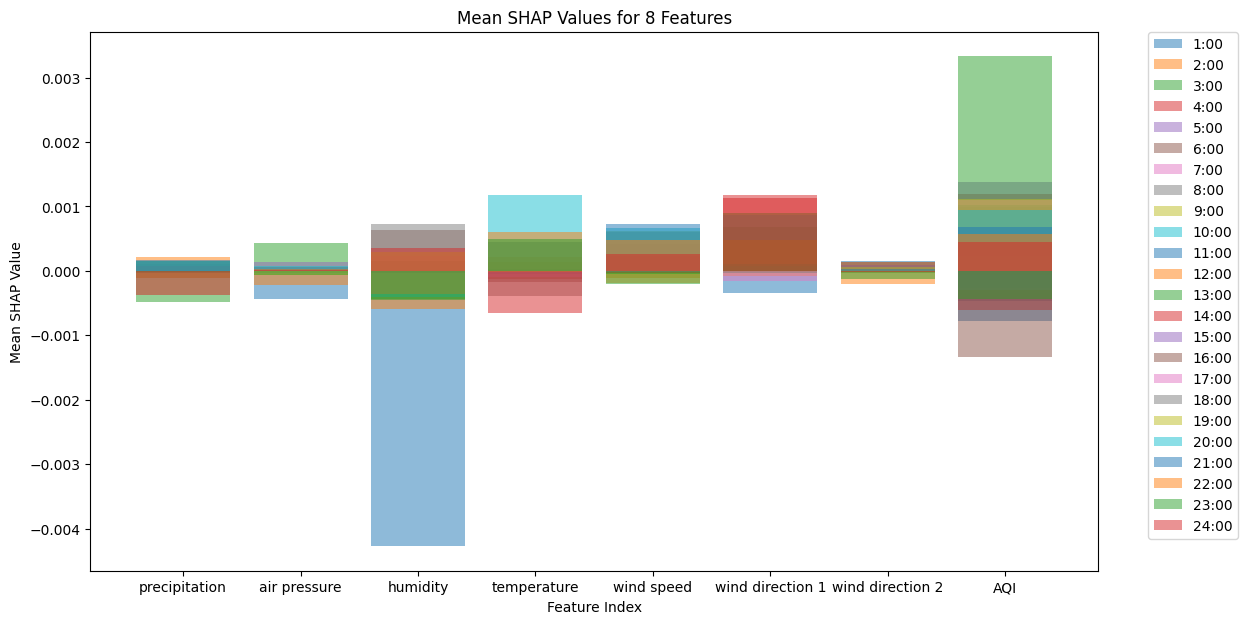

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# shap_value[0]을 가져옴
shap_value = shap_values[0]

# 첫 번째와 다섯 번째 차원만 남김
shap_mean = np.mean(shap_value, axis=(0, 1, 4))  # (24, 8) 형태

x_labels = ["precipitation", "air pressure", "humidity", "temperature", "wind speed", "wind direction 1", "wind direction 2", "AQI"]


plt.figure(figsize=(13, 7))
for i in range(shap_mean.shape[0]):
    plt.bar(np.arange(shap_mean.shape[1]), shap_mean[i], alpha=0.5, label=f"{i+1}:00")

plt.xticks(ticks=np.arange(shap_mean.shape[1]), labels=x_labels)

plt.xlabel("Feature Index")
plt.ylabel("Mean SHAP Value")
plt.title("Mean SHAP Values for 8 Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


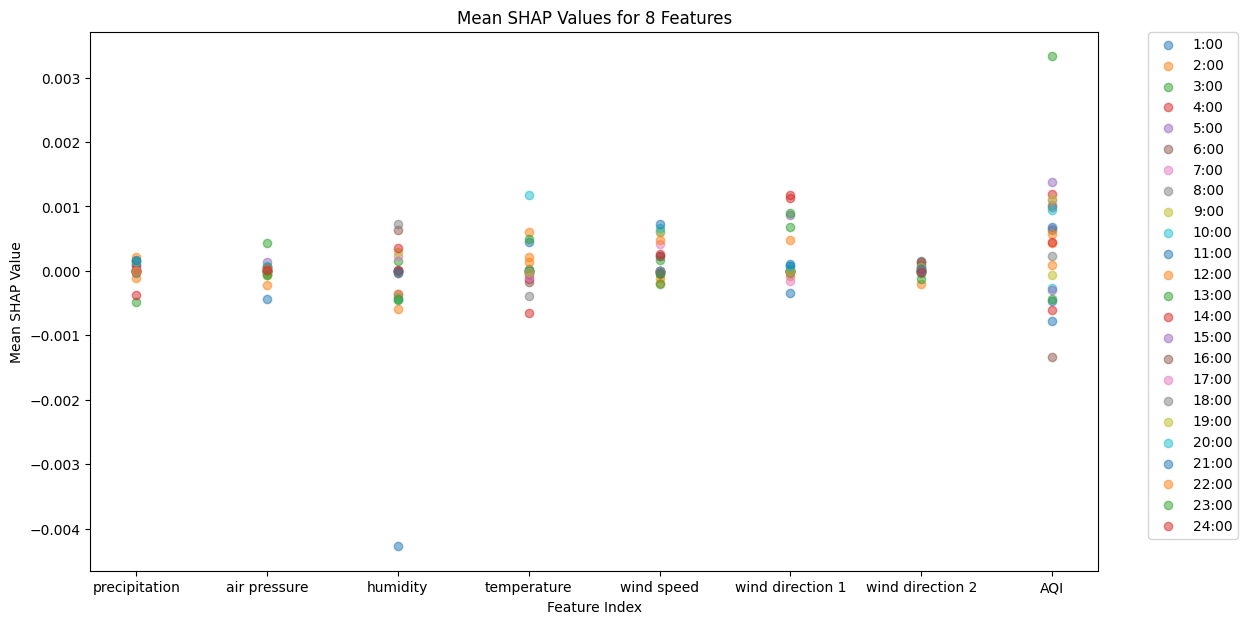

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# shap_value[0]을 가져옴
shap_value = shap_values[0]

# 첫 번째와 다섯 번째 차원만 남김
shap_mean = np.mean(shap_value, axis=(0, 1, 4))  # (24, 8) 형태

x_labels = ["precipitation", "air pressure", "humidity", "temperature", "wind speed", "wind direction 1", "wind direction 2", "AQI"]

plt.figure(figsize=(13, 7))
for i in range(shap_mean.shape[0]):
    plt.scatter(np.arange(shap_mean.shape[1]), shap_mean[i], label=f"{i+1}:00", alpha=0.5)

plt.xticks(ticks=np.arange(shap_mean.shape[1]), labels=x_labels)

plt.xlabel("Feature Index")
plt.ylabel("Mean SHAP Value")
plt.title("Mean SHAP Values for 8 Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


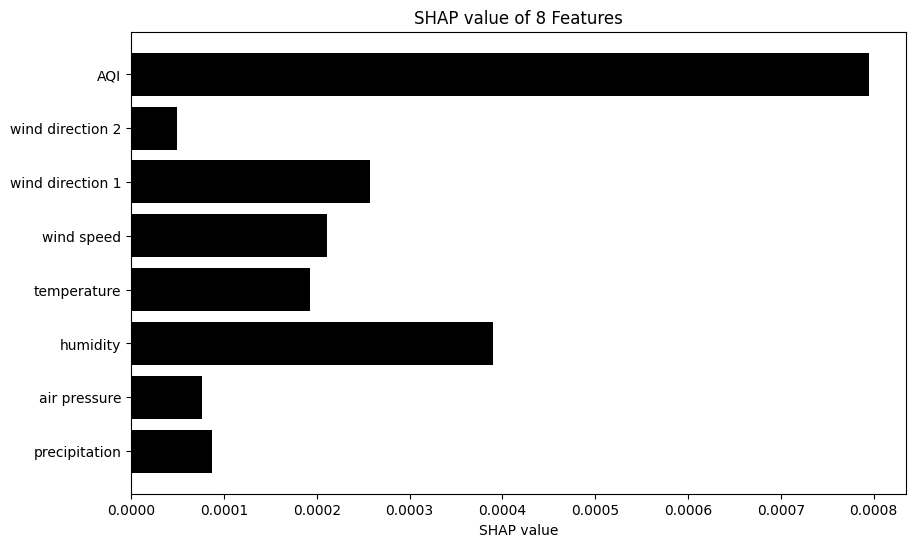

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 전치하여 각 열끼리의 절대값 평균 계산
column_mean = np.mean(np.abs(shap_mean.T), axis=1)
# 막대 그래프로 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(np.arange(len(column_mean)), column_mean,color='black')
plt.yticks(np.arange(len(column_mean)), ["precipitation", "air pressure", "humidity", "temperature", "wind speed", "wind direction 1", "wind direction 2", "AQI"])
plt.xlabel('SHAP value')
plt.title('SHAP value of 8 Features')

plt.show()



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (5, 4) + inhomogeneous part.

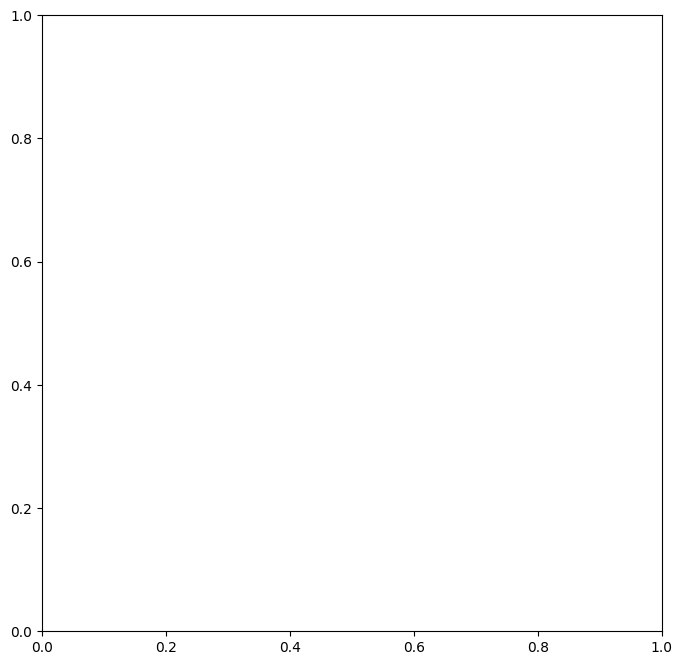

In [219]:
## Dot Plot (미완성)
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False


fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(shap_values, x_labels,
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()